In [ ]:
! pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Import Twitter Sentiment Dataset using API

In [ ]:
!kaggle datasets download -d kazanova/sentiment140

 88% 71.0M/80.9M [00:00<00:00, 130MB/s]
100% 80.9M/80.9M [00:00<00:00, 120MB/s]


# Extracting the compressed dataset

In [ ]:
from zipfile import ZipFile
dataset ='/content/sentiment140.zip'
with ZipFile(dataset,'r') as Zip:
  Zip.extractall()
  print("The dataset is extracted")


The dataset is extracted


# Import the dependencies

In [ ]:
import numpy as np
import pandas as pd
import re #re stands for regular expression.....used for pattern matching and search on data
from nltk.corpus import stopwords #nltk stands fro natural language toolkit
from nltk.stem.porter import PorterStemmer #used for the process of stemming where we have to reduce the word to its stem
from sklearn.feature_extraction.text import TfidfVectorizer #TfidfVectorizer converts the textual data to numeric data
from sklearn.model_selection import train_test_split #splitting the data into train data and split data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#printing stopwords in english
print(stopwords.words('english'))
# stopwords are the words which which do not add any influential meaning(contextual importance) to the data that means if we remove them it wont make any difference in the analysis. We have to remove them before using our ML model

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

# Data Processing

In [ ]:
# loading the data from csv file to pandas dataframe
twitter_data=pd.read_csv('/content/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1')


In [ ]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column                                                                                                               Non-Null Count    Dtype 
---  ------                                                                                                               --------------    ----- 
 0   0                                                                                                                    1599999 non-null  int64 
 1   1467810369                                                                                                           1599999 non-null  int64 
 2   Mon Apr 06 22:19:45 PDT 2009                                                                                         1599999 non-null  object
 3   NO_QUERY                                                                                                             1599999 non-null  object
 4   _

In [ ]:
twitter_data.shape


(1599999, 6)

In [ ]:
#printing the first 10 rows of the dataframe
twitter_data.head(10)

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
5,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
6,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
7,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
8,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?
9,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break in plain city... it's snowing


In [ ]:
#previously the first tweet is also read as a column name so naming the columns and reading the dataset again
column_name=['target','id','date','flag','user','text']
# loading the data from csv file to pandas dataframe
twitter_data=pd.read_csv('/content/training.1600000.processed.noemoticon.csv',names=column_name,encoding='ISO-8859-1')



In [ ]:
twitter_data.shape


(1600000, 6)

In [ ]:
twitter_data.head(10)

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [ ]:
twitter_data.describe()

,target,id
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [ ]:
#dropping the id column as it is not needed in the dataset
twitter_data=twitter_data.drop(['id','date','flag','user'],axis=1)

#  Explore teh dataset

array([[<Axes: title={'center': 'target'}>]], dtype=object)

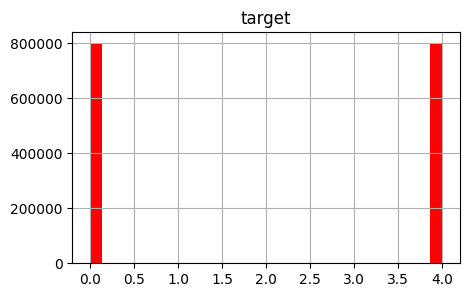

In [ ]:
twitter_data.hist(bins=30,figsize=(5,3),color='r')

In [ ]:
# counting the length of the messages
twitter_data['length']=twitter_data['text'].apply(len)
twitter_data

,target,text,length
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115
1,0,is upset that he can't update his Facebook by ...,111
2,0,@Kenichan I dived many times for the ball. Man...,89
3,0,my whole body feels itchy and like its on fire,47
4,0,"@nationwideclass no, it's not behaving at all....",111
...,...,...,...
1599995,4,Just woke up. Having no school is the best fee...,56
1599996,4,TheWDB.com - Very cool to hear old Walt interv...,78
1599997,4,Are you ready for your MoJo Makeover? Ask me f...,57
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...,65


<Axes: ylabel='Frequency'>

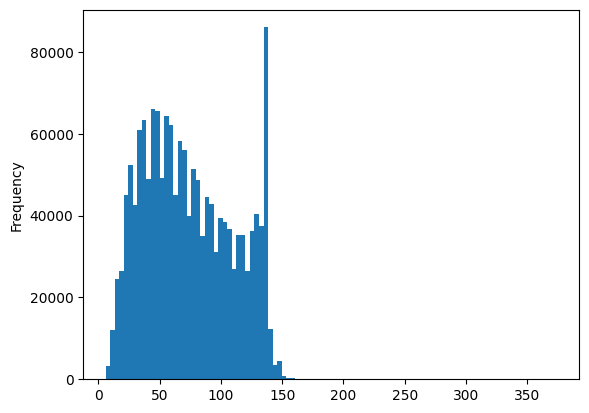

In [ ]:
twitter_data['length'].plot(bins=100,kind='hist')

In [ ]:
twitter_data.describe()

,target,length
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,7.409011e+01
std,2.000001e+00,3.644114e+01
min,0.000000e+00,6.000000e+00
25%,0.000000e+00,4.400000e+01
50%,2.000000e+00,6.900000e+01
75%,4.000000e+00,1.040000e+02
max,4.000000e+00,3.740000e+02


In [ ]:
#viewing the shortest tweet
twitter_data[twitter_data['length']==6]['text'].iloc[0]


' just '

In [ ]:
#viewing the shortest tweet
twitter_data[twitter_data['length']==374]['text'].iloc[0]

'@catfish_ohm à¹\x80à¸\x84à¹\x89à¸²à¹\x83à¸«à¹\x89à¸?à¸²à¸£à¹\x8cà¸\x95à¸¹à¸\x99à¸?à¸¸à¹\x82à¸£à¸°(à¸ªà¸±à¸ªà¹\x86+à¸¢à¸¹à¸£à¸´à¹?à¸?à¹\x84à¸\x94à¹\x89à¹?à¸\x97à¸\x99à¸\x99à¸°à¸\x9eà¸\xadà¸\x94à¸µà¸¡à¸´à¹\x82à¸?à¸°à¸«à¸§à¸\x87(à¸\x82à¸\x99à¸²à¸\x94à¹\x80à¸\x9fà¸´à¸\x99à¹?à¸?à¸¢à¸±à¸\x87à¹\x80à¸\x84à¸¢à¹\x83à¸«à¹\x89à¹\x84à¸¡à¹\x88à¹\x83à¸\x8aà¹\x88à¹\x80à¸«à¸£à¸\xad.à¹?à¸\x95à¹\x88à¸\x8aà¹\x88à¸²à¸\x87à¹\x80à¸«à¸\xadà¸°à¸£à¸²à¸¢à¸\x99à¸±à¹\x89à¸\x99à¹\x80à¸\x82à¸²à¹\x82à¸¡à¹\x80à¸\xadà¸°à¸?à¸§à¹\x88à¸²à¸\x9bà¸¥à¸²à¹?à¸¡à¸§à¹\x80à¸¢à¸\xadà¸° = '

In [ ]:
#Counting the number of missing values in the dataset
twitter_data.isnull().sum()

target    0
text      0
length    0
dtype: int64

In [ ]:
# checking the distribution of target column checking how many positive tweets are there and
#how many negative tweets are there.....
#because if the datasets are not even then we have to perform upsampling and downsampling
twitter_data['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

In [ ]:
#Convert the target 4 to 1
twitter_data.replace({'target':{4:1}},inplace=True)
twitter_data['target'].value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

In [ ]:
positive=twitter_data[twitter_data['target']==1]
negative=twitter_data[twitter_data['target']==0]

# Plot the Worldcloud

In [ ]:
!pip install WordCloud
from wordcloud import WordCloud

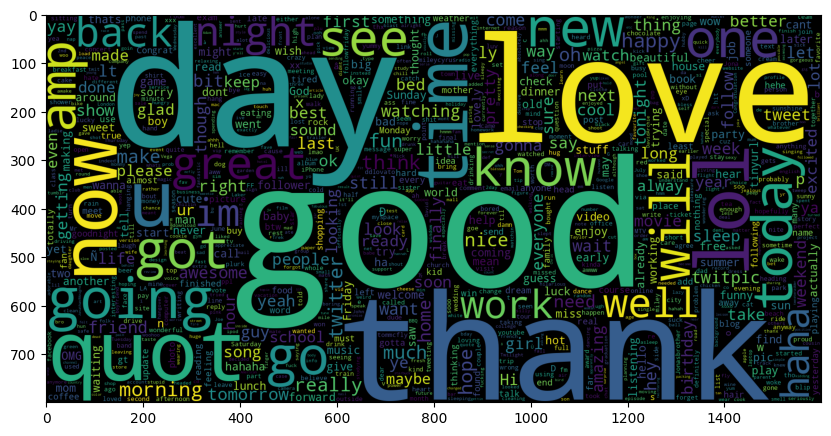

In [ ]:

#convert all the tweets in a single list
sentence=positive['text'].tolist()
sentences_as_one_string=" ".join(sentence)
plt.figure(figsize=(10,10))
plt.imshow(WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(sentences_as_one_string))

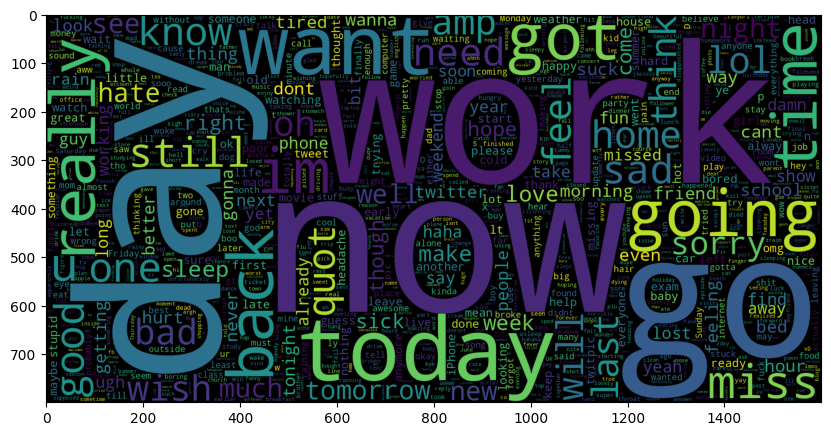

In [ ]:
n_sentence=negative['text'].tolist()
n_sentences_as_one_string=" ".join(n_sentence)
plt.figure(figsize=(10,10))
plt.imshow(WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(n_sentences_as_one_string))

## **Stemming** ---a process of reducing a word to its root word

In [ ]:
port_stem=PorterStemmer()

In [ ]:

def stemming(content):
  stemmed_content=re.sub('[^a-zA-Z]',' ',content) # if there is any word or character which is not a letter(uppercase/lowercase) then remove it(using ^)
  stemmed_content=stemmed_content.lower()
  stemmed_content=stemmed_content.split()
  stemmed_content=[port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content=' '.join(stemmed_content) #joining all the tweets together
  return stemmed_content



In [ ]:
twitter_data['stemmed_content'] = twitter_data['text'].apply(stemming)

In [ ]:
twitter_data.head(10)

,target,text,length,stemmed_content
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115,switchfoot http twitpic com zl awww bummer sho...
1,0,is upset that he can't update his Facebook by ...,111,upset updat facebook text might cri result sch...
2,0,@Kenichan I dived many times for the ball. Man...,89,kenichan dive mani time ball manag save rest g...
3,0,my whole body feels itchy and like its on fire,47,whole bodi feel itchi like fire
4,0,"@nationwideclass no, it's not behaving at all....",111,nationwideclass behav mad see
5,0,@Kwesidei not the whole crew,29,kwesidei whole crew
6,0,Need a hug,11,need hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...,99,loltrish hey long time see ye rain bit bit lol...
8,0,@Tatiana_K nope they didn't have it,36,tatiana k nope
9,0,@twittera que me muera ?,25,twittera que muera


In [ ]:
print(twitter_data['stemmed_content'])

0          switchfoot http twitpic com zl awww bummer sho...
1          upset updat facebook text might cri result sch...
2          kenichan dive mani time ball manag save rest g...
3                            whole bodi feel itchi like fire
4                              nationwideclass behav mad see
                                 ...                        
1599995                           woke school best feel ever
1599996    thewdb com cool hear old walt interview http b...
1599997                         readi mojo makeov ask detail
1599998    happi th birthday boo alll time tupac amaru sh...
1599999    happi charitytuesday thenspcc sparkschar speak...
Name: stemmed_content, Length: 1600000, dtype: object


In [ ]:
print(twitter_data['target'])

0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: target, Length: 1600000, dtype: int64


In [ ]:
#separating the data and the label
X=twitter_data['stemmed_content'].values
Y=twitter_data['target'].values

In [ ]:
print(X)

['switchfoot http twitpic com zl awww bummer shoulda got david carr third day'
 'upset updat facebook text might cri result school today also blah'
 'kenichan dive mani time ball manag save rest go bound' ...
 'readi mojo makeov ask detail'
 'happi th birthday boo alll time tupac amaru shakur'
 'happi charitytuesday thenspcc sparkschar speakinguph h']


In [ ]:
print(Y)

[0 0 0 ... 1 1 1]


# Splitting the data to train data and test data

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,stratify=Y, random_state=2)  #stratify=Y....this means that there is a 50% split of 0 and 1 target values in the train and test data otherwise all 0 or all 1 value might go to one dataset


In [ ]:
print(X.shape,X_train.shape,X_test.shape)

(1600000,) (1280000,) (320000,)


In [ ]:
print(Y.shape,Y_train.shape,Y_test.shape)

(1600000,) (1280000,) (320000,)


In [ ]:
# import pickle
# from google.colab import drive

# data_splits = {
#     'X_train': X_train,
#     'X_test': X_test,
#     'Y_train': Y_train,
#     'Y_test': Y_test
# }

# # Mount Google Drive
# drive.mount('/content/drive')




Mounted at /content/drive


In [ ]:
# # Specify the directory in your Google Drive to save the data files
# data_dir = '/content/drive/MyDrive/Twitter_Sentiment_Analysis/'

# # Save the serialized data splits to Google Drive
# with open(data_dir + 'data_splits.pkl', 'wb') as f:
#     pickle.dump(data_splits, f)

In [ ]:
# # Load the serialized data splits from Google Drive
# with open('/content/drive/My Drive/Twitter_Sentiment_Analysis/data_splits.pkl', 'rb') as f:
#     data_splits = pickle.load(f)

# # Retrieve the data splits
# X_train = data_splits['X_train']
# X_test = data_splits['X_test']
# Y_train = data_splits['Y_train']
# Y_test = data_splits['Y_test']

# Feature Extraction

In [ ]:
#converting the textual data to numeric data
vectorizer=TfidfVectorizer() #convert all the words to numeric value
X_train=vectorizer.fit_transform(X_train) #all the train data will be taken and based on this data
#vectorizer will give score to all individual words and the text will be transformed to numeric value
X_test=vectorizer.transform(X_test)  #we also have to transform the test data to its numeric value

In [ ]:
print(X_train)

  (0, 443066)	0.4484755317023172
  (0, 235045)	0.41996827700291095
  (0, 109306)	0.3753708587402299
  (0, 185193)	0.5277679060576009
  (0, 354543)	0.3588091611460021
  (0, 436713)	0.27259876264838384
  (1, 160636)	1.0
  (2, 288470)	0.16786949597862733
  (2, 132311)	0.2028971570399794
  (2, 150715)	0.18803850583207948
  (2, 178061)	0.1619010109445149
  (2, 409143)	0.15169282335109835
  (2, 266729)	0.24123230668976975
  (2, 443430)	0.3348599670252845
  (2, 77929)	0.31284080750346344
  (2, 433560)	0.3296595898028565
  (2, 406399)	0.32105459490875526
  (2, 129411)	0.29074192727957143
  (2, 407301)	0.18709338684973031
  (2, 124484)	0.1892155960801415
  (2, 109306)	0.4591176413728317
  (3, 172421)	0.37464146922154384
  (3, 411528)	0.27089772444087873
  (3, 388626)	0.3940776331458846
  (3, 56476)	0.5200465453608686
  :	:
  (1279996, 390130)	0.22064742191076112
  (1279996, 434014)	0.2718945052332447
  (1279996, 318303)	0.21254698865277746
  (1279996, 237899)	0.2236567560099234
  (1279996, 2910

In [ ]:
print(X_test)

  (0, 420984)	0.17915624523539803
  (0, 409143)	0.31430470598079707
  (0, 398906)	0.3491043873264267
  (0, 388348)	0.21985076072061738
  (0, 279082)	0.1782518010910344
  (0, 271016)	0.4535662391658828
  (0, 171378)	0.2805816206356073
  (0, 138164)	0.23688292264071403
  (0, 132364)	0.25525488955578596
  (0, 106069)	0.3655545001090455
  (0, 67828)	0.26800375270827315
  (0, 31168)	0.16247724180521766
  (0, 15110)	0.1719352837797837
  (1, 366203)	0.24595562404108307
  (1, 348135)	0.4739279595416274
  (1, 256777)	0.28751585696559306
  (1, 217562)	0.40288153995289894
  (1, 145393)	0.575262969264869
  (1, 15110)	0.211037449588008
  (1, 6463)	0.30733520460524466
  (2, 400621)	0.4317732461913093
  (2, 256834)	0.2564939661498776
  (2, 183312)	0.5892069252021465
  (2, 89448)	0.36340369428387626
  (2, 34401)	0.37916255084357414
  :	:
  (319994, 123278)	0.4530341382559843
  (319995, 444934)	0.3211092817599261
  (319995, 420984)	0.22631428606830145
  (319995, 416257)	0.23816465111736276
  (319995, 3

# Model Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
def model_evaluate(model):

  #accuracy score on training data
  train_prediction=model.predict(X_train) # here we are only giving the tweets so that the model can predict the labels of the tweets where it will be a 0(negative) or 1(positive)
  training_data_accuracy=accuracy_score(Y_train,train_prediction) #compare the X_train_predictions(predicted values) with the true labels
  print("Accuracy score on the training data: ",training_data_accuracy)

  #accuracy score on test data
  test_prediction=model.predict(X_test) # here we are only giving the tweets so that the model can predict the labels of the tweets where it will be a 0(negative) or 1(positive)
  test_data_accuracy=accuracy_score(Y_test,test_prediction) #compare the X_train_predictions(predicted values) with the true labels
  print("Accuracy score on the test data: ",test_data_accuracy)

  # classification report
  print(classification_report(Y_test, test_prediction))

  # confusion report
  cf_matrix = confusion_matrix(Y_test, test_prediction)
  categories = ['Negative', 'Positive']
  group_names = ['True Negative', 'False Positive','False Negative','True Positive']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

  labels = list(map(lambda v1, v2: f'{v1}\n{v2}', group_names, group_percentages))

  labels = np.asarray(labels).reshape(2,2)

  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


# Training the Logistic Regression model

In [ ]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(C =2, max_iter=1000, n_jobs=1) #maximum number of times the model has to go through the data
model.fit(X_train,Y_train)


LogisticRegression(C=2, max_iter=1000, n_jobs=1)

Accuracy score on the training data:  0.82586875
Accuracy score on the test data:  0.777903125
              precision    recall  f1-score   support

           0       0.79      0.76      0.77    160000
           1       0.77      0.79      0.78    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



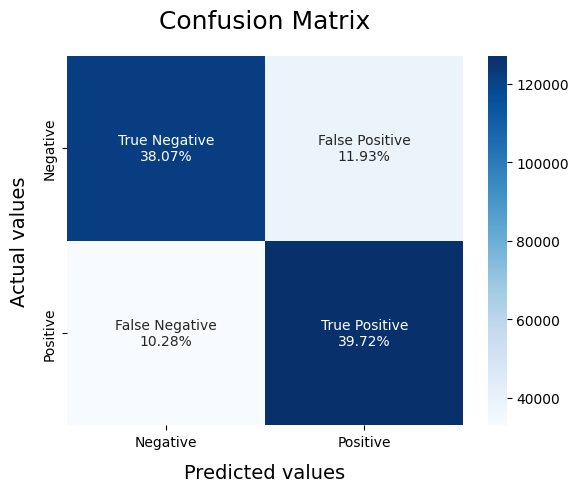

In [ ]:
model_evaluate(model)

# Training Naive Bayes model

Accuracy score on the training data:  0.8026609375
Accuracy score on the test data:  0.76580625
              precision    recall  f1-score   support

           0       0.75      0.79      0.77    160000
           1       0.78      0.74      0.76    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



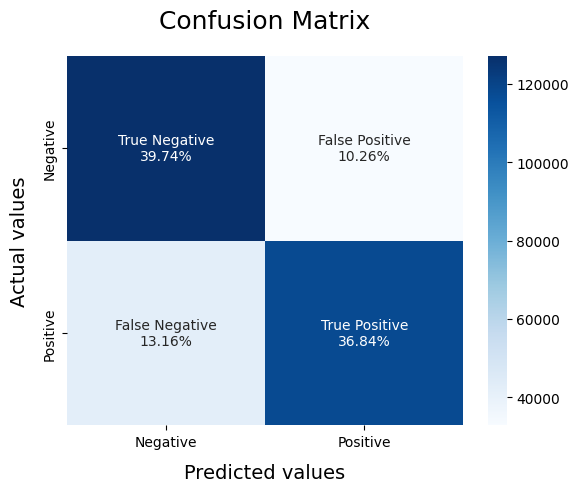

In [ ]:
from sklearn.naive_bayes import BernoulliNB
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, Y_train)
model_evaluate(BNBmodel)

# Training Linear Support Vector Classification (LinearSVC) model

Accuracy score on the training data:  0.862340625
Accuracy score on the test data:  0.769675
              precision    recall  f1-score   support

           0       0.78      0.76      0.77    160000
           1       0.76      0.78      0.77    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



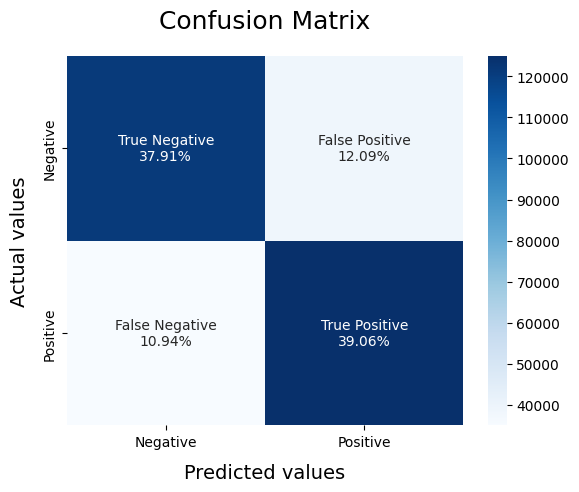

In [ ]:
from sklearn.svm import LinearSVC
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, Y_train)
model_evaluate(SVCmodel)

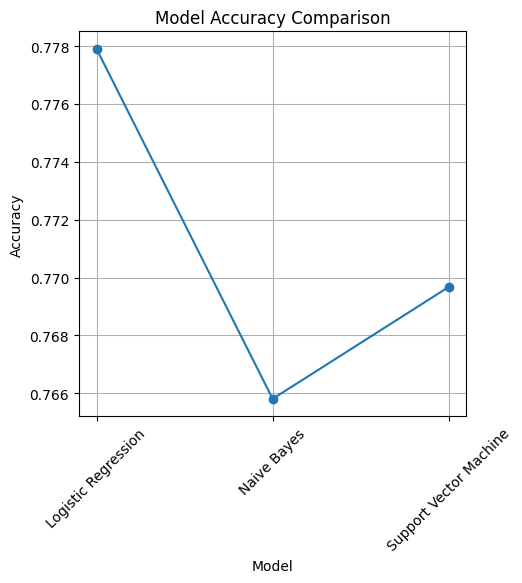

In [ ]:
import matplotlib.pyplot as plt

def model_evaluate(models, X_test, Y_test):
    accuracies = []
    for name, model in models.items():
        accuracy = model.score(X_test, Y_test)
        accuracies.append((name, accuracy))
    return accuracies

# Assuming you have models named LRModel, NBModel, and SVMModel
models = {
    'Logistic Regression': model,
    'Naive Bayes': BNBmodel,
    'Support Vector Machine': SVCmodel
}

# Assuming you have X_test and y_test
accuracies = model_evaluate(models, X_test, Y_test)

# Extract model names and accuracies
model_names = [name for name, _ in accuracies]
accuracy_values = [accuracy for _, accuracy in accuracies]

# Plotting the line chart
plt.figure(figsize=(5, 5))
plt.plot(model_names, accuracy_values, marker='o')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Saving the models

In [ ]:
from joblib import dump

# Again, specifying base path
base_path = "/content/gdrive/MyDrive/"

# Save Logistic Regression model
model_save_name = 'logistic_regression_classifier.joblib'
path = f"{base_path}{model_save_name}"
dump(model, path)

# Save Naive Bayes model
model_save_name = 'naive_bayes_classifier.joblib'
path = f"{base_path}{model_save_name}"
dump(BNBmodel, path)

# Save SVM model
model_save_name = 'svm_classifier.joblib'
path = f"{base_path}{model_save_name}"
dump(SVCmodel, path)


['/content/gdrive/MyDrive/svm_classifier.joblib']

In [ ]:
from joblib import load
def load_models():

    # Loading the logistic regression model
    LR_model = 'logistic_regression_classifier.joblib'
    path = f"/content/gdrive/My Drive/{LR_model}"

    # Load the model from the file
    LRModel = load(path)


    # Loading the naive bayes model
    NB_model = 'naive_bayes_classifier.joblib'
    path = f"/content/gdrive/My Drive/{NB_model}"

    # Load the model from the file
    NBModel = load(path)


    # Loading the SVM model
    SVM_model = 'svm_classifier.joblib'
    path = f"/content/gdrive/My Drive/{SVM_model}"

    # Load the model from the file
    SVMModel = load(path)

    return LRModel,NBModel,SVMModel



In [ ]:
X_new=X_test[200]
print(Y_test[200])

1


In [ ]:

LRModel, NBModel, SVMModel = load_models()
prediction=SVMModel.predict(X_new)
print(prediction)
if(prediction[0]==0):
  print("Negative Tweet")
else:
  print("Positive Tweet")

[1]
Positive Tweet


In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.stem import WordNetLemmatizer
def preprocess(textdata):
    processedText = []

    # Create Lemmatizer and Stemmer
    wordLemm = WordNetLemmatizer()

    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

    for tweet in textdata:
        tweet = tweet.lower()


        tweet = re.sub(urlPattern,' URL',tweet)

        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])

        tweet = re.sub(userPattern,' USER', tweet)

        tweet = re.sub(alphaPattern, " ", tweet)

        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        tweetwords = ''
        for word in tweet.split():

            if len(word)>1:

                word = wordLemm.lemmatize(word)

                tweetwords += (word+' ')
        processedText.append(tweetwords)

    return processedText

In [ ]:
import pandas as pd

def predict(LRModel, NBModel, SVMModel, text, vectorizer, preprocess):
    # Transform the text data to the correct format
    textdata = vectorizer.transform(preprocess(text))

    # Make predictions using each model
    LR_predictions = LRModel.predict(textdata)
    NB_predictions = NBModel.predict(textdata)
    SVM_predictions = SVMModel.predict(textdata)

    # Make a list of text with sentiment predictions for each model.
    data = []
    for i in range(len(text)):
        data.append((text[i], LR_predictions[i], NB_predictions[i], SVM_predictions[i]))

    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns=['text', 'LR_sentiment', 'NB_sentiment', 'SVM_sentiment'])
    df = df.replace([0, 1], ["Negative", "Positive"])
    return df

if __name__ == "__main__":
    # Loading the models.
    LRModel, NBModel, SVMModel = load_models()
    # Text to classify should be in a list.
    text = [
        "I hate our president",
        "I Love you.",
        "Yes! We can win",
        "i am happy"
    ]

    df = predict(LRModel, NBModel, SVMModel, text, vectorizer, preprocess)
    print(df.head())


                   text LR_sentiment NB_sentiment SVM_sentiment
0  I hate our president     Negative     Negative      Negative
1           I Love you.     Positive     Positive      Positive
2       Yes! We can win     Positive     Positive      Negative
3            i am happy     Positive     Negative      Positive
